## Notebook to fit a second order polynomial to some data with outliers

#### Will be usefull for something related to AVO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
def l2_norm(A,y):
    """
    Least squares or L2-norm solution.
    Aster, R.C., Borchers, B., Thurber, C.H., 2018.
    Parameter estimation and inverse problems, 3rd edition, Page 26

    Parameters
    ----------
    A : 2D array
        The sensitivity matrix.
    y : array
        Input data.

    Returns
    -------
    pest : array
        Estimated parameters
    predict : array
       Predicted data.
    res : array
       Residuals of the fit.
    """

    pest = np.linalg.solve(np.dot(A.T,A),np.dot(A.T,y))
    predict = np.dot(A,pest)
    res = y - predict

    return(pest,predict,res)

In [3]:
def l1_norm(A,y,itmax=20):
    """
    L1-norm solution - Iteratively reweighted least squares IRLS.
    Aster, R.C., Borchers, B., Thurber, C.H., 2018.
    Parameter estimation and inverse problems, 3rd edition, Page 46

    Parameters
    ----------
    A : 2D array
        The sensitivity matrix.
    y : array
        Input data.
    itmax : integer
        The number of iterations.

    Returns
    -------
    pest0 : array
        Estimated parameters.
    predict_list : list
        Predicted data on each iteration
    phi_it : list
        Norm of the residuals.
    it : integer
        Number of iterations.
    np.dot(A,pest0) : array
       Predicted data.
    y - np.dot(A,pest0) : array
       Residuals of the fit. 
    """
    
    #initial guess from L2 norm
    pest0 = np.linalg.solve(np.dot(A.T,A),np.dot(A.T,y))
    predict0 = np.dot(A,pest0)
    r = y - predict0
    phi0 = np.sum(np.abs(r))
    it = 0 
    phi_it = [phi0] #initialize he residual list
    predict_list = [predict0]
    
    for i in range(itmax):
        
        #the process is updated because of the vector r
        R = np.diag(1./np.abs(r+1e-15))
        ATR = np.dot(A.T,R)
        pest = np.linalg.solve(np.dot(ATR,A),np.dot(ATR,y))
        predict = np.dot(A,pest)
        r = y - predict        
        phi = np.sum(np.abs(r))                
        #stop criteria     
        if (np.abs(phi - phi0)/np.abs(phi)) > 1e-5:
            pest0 = np.copy(pest)
            phi0 = np.copy(phi)
            predict0 = np.copy(predict)
        else:
            break              
        #update the list        
        phi_it.append(phi) 
        predict_list.append(predict0)
        it+=1
        
    return pest0, predict_list, phi_it, it+1, np.dot(A,pest0), y - np.dot(A,pest0)

In [4]:
def plot_l1l2(x,y1,y,predict_l1,predict_l2,res_l1,res_l2,itera,phi_itl1):
    """
    Plot the fit with the L1 and L2 norms, the residuals and the L1 norm of the residuals by the number of iterations.
    """
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title('(a)')
    plt.plot(x,y1,'-',color='k',linewidth=3,label='input smooth')
    plt.plot(x,y,'--o',label='input outlier')
    plt.plot(x,predict_l2,'o',color='darkgreen',label='predicted - L2-norm')
    plt.plot(x,predict_l1,'*',color='darkorange',label='predicted - L1-norm')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('data', fontsize=12)
    plt.xlim(np.floor(np.min(x))-0.2,np.ceil(np.max(x)))
    plt.legend()
    plt.grid(linestyle='--')
    
    plt.subplot(1,3,2)
    plt.title('(b)')
    plt.plot(x,res_l2,'o',color='darkgreen',label='L2-norm')
    plt.plot(x,res_l1,'*',color='darkorange',label='L1-norm')
    plt.xlabel('x', fontsize=12)
    plt.ylabel('residuals', fontsize=12)
    plt.xlim(np.floor(np.min(x))-0.2,np.ceil(np.max(x)))
    plt.legend()
    plt.grid(linestyle='--')
    
    plt.subplot(1,3,3)
    plt.title('(c)')
    plt.plot(np.arange(0,itera),phi_itl1,'x-',color='k', markersize=4)
    plt.ylabel('$||Gm-d||_1$', fontsize=12)
    plt.xlabel('Iterations', fontsize=12)
    plt.grid(linestyle='--')
    
    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    
    return

In [5]:
def plot_l1solutions(x,y1,y,pest_listl1,predict_l2,itera):
    """
    Plot the fit with the L1 and L2 norms, here the fit with L1 norm is updated on each iteration.
    """
    alphabet_string=string.ascii_lowercase
    alphabet_list = list(alphabet_string)
    plt.figure(figsize=(12,12))
    for i in range(itera):        
        plt.subplot(3,3,i+1)
        plt.title('('+alphabet_list[i]+') iteration %d'%i)
        plt.plot(x,y1,'-',color='k',linewidth=3,label='input smooth')
        plt.plot(x,y,'--o',label='input outlier')
        plt.plot(x,predict_l2,'o',color='darkgreen',label='predicted - L2-norm')
        plt.plot(x,pest_listl1[i],'*',color='darkorange',label='predicted - L1-norm')
        plt.xlabel('x', fontsize=12)
        plt.ylabel('data', fontsize=12)
        plt.xlim(np.floor(np.min(x))-0.2,np.ceil(np.max(x)))
        plt.legend()
        plt.grid(linestyle='--')
        plt.tight_layout()
    
    return

### Initialization

In [6]:
#input variables
x=np.arange(0,20,1)
#function to generate the polynomial input data, normalized
y1=(3*x+x**2)/np.max(3*x+x**2)
y=np.copy(y1)
#create outliers
y[10]-=0.5 ; y[11]-=0.5
#sensitivity matrix - fit with a second order polynomial 
A=np.vstack((x**0,x**1,x**2)).T

### Here is the computation

In [7]:
# L2-norm
pest_l2,predict_l2,res_l2=l2_norm(A,y)
# L1-norm
pest_l1, predict_listl1, phi_itl1,itera, predict_l1, res_l1 = l1_norm(A,y)

### Plot the fit with the L1 and L2 norms, the residuals and the L1 norm of the residuals by the number of iterations.

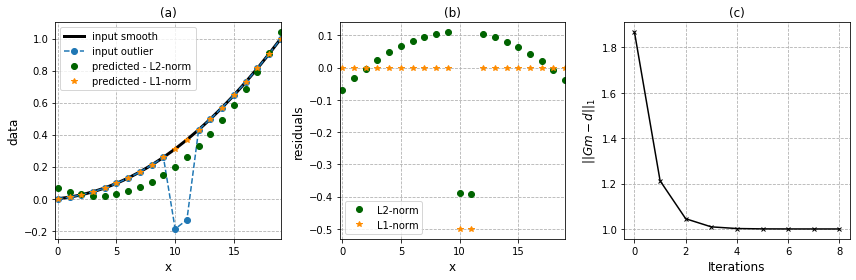

In [8]:
#plot
plot_l1l2(x,y1,y,predict_l1,predict_l2,res_l1,res_l2,itera,phi_itl1)

### Plot the fit with the L1 and L2 norms, here the fit with L1 norm is updated on each iteration, figure (i) below corresponds to figure (a) above.

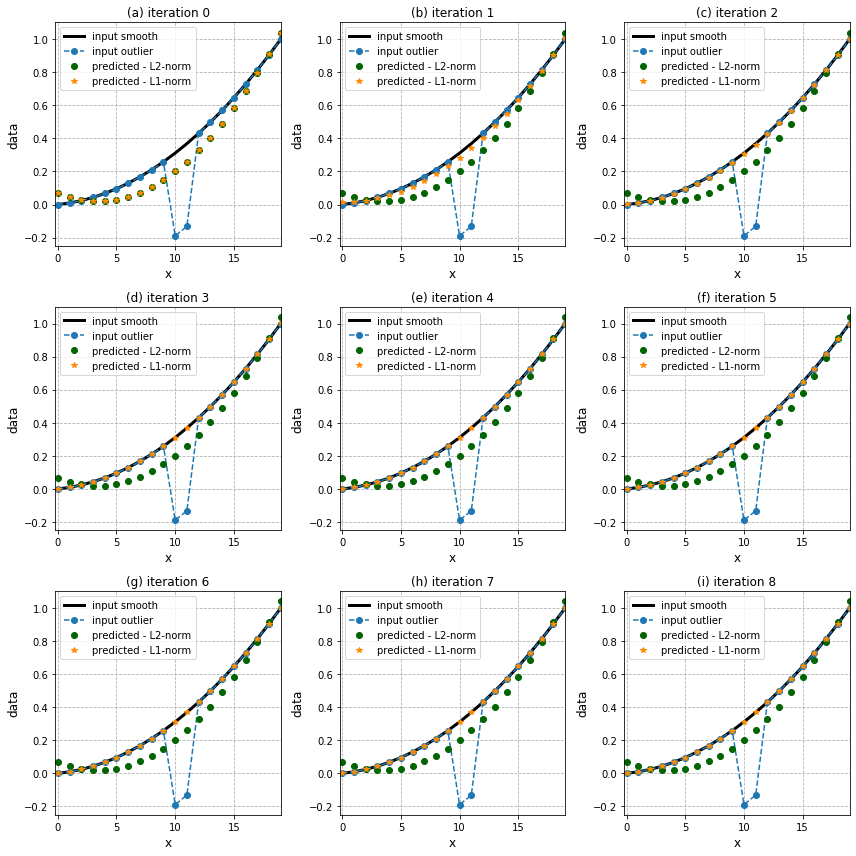

In [9]:
#plot
plot_l1solutions(x,y1,y,predict_listl1,predict_l2,itera)